## Boy or Girl? A Machine Learning Web App to Detect Gender from Name

- Obtaining a name to the gender training dataset
- Preprocessing the names to make them compatible with Machine Learning (ML) models
- Developing a Natural Language Processing (NLP) ML model to read in a name and output if it’s a boy’s name or a girl’s name

https://towardsdatascience.com/boy-or-girl-a-machine-learning-web-app-to-detect-gender-from-name-16dc0331716c

In [248]:
import pandas as pd

In [249]:
names_df = pd.read_csv('./heroku-apps/src/boyorgirl/data/us-names.csv')
names_df.head()

,name,gender
0,Mary,F
1,Annie,F
2,Anna,F
3,Margaret,F
4,Helen,F


### Data Preprocessing
<p>Human names are textual data, while ML models can only work with numeric data. To convert our text into a numeric representation, we’ll do the following steps.</p>

- Lowercase the name since each character’s case doesn’t convey any information about a person’s gender.

- Split each character: The basic idea of the ML model we’re building is to read characters in a name to identify patterns that could indicate masculinity or femininity. Thus we split the name into each character.

- Pad names with empty spaces until a max of 50 characters ensures the ML model sees the same length for all the names.

- Encode each character to a unique number since ML models can only work with numbers. In this case, we encode ‘ ’ (space) to 0, ‘a’ to 1, ‘b’ to 2, and so on.

- Encode each gender to a unique number since ML models can only work with numbers. In this case, we encode ‘F’ to 0 and ‘M’ to 1.

In [251]:
def stop_words(name: str):
    words = [
        {'name': '_', 'value': ' '},
        {'name': 'é', 'value': 'e'},
        {'name': 'ï', 'value': 'i'},
        {'name': 'ë', 'value': 'e'},
        {'name': 'è', 'value': 'e'},
        {'name': 'ü', 'value': 'u'}
    ]
    
    
    for word in words:
        name = name.replace(word['name'], word['value'])
        
    return name

In [252]:
def preprocess(names_df, train=True):
    # Step 1: Lowercase
    names_df['name'] = names_df['name'].str.lower()
    
    # Step 2: Split individual characters
    names_df['name'] = [list(stop_words(name)) for name in names_df['name']]
    
    # Step 3: Pad names with spaces to make all names same length
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]
    
    # Step 4: Encode characters to numbers
    names_df['name'] = [
        [ max(0.0, ord(char)-96.0) for char in name]
        for name in names_df['name']
    ]
    
    if train:
        # Step 5: Encode Gender to Numbers
        names_df['gender'] = [
            0.0 if gender=='F' else 1.0 
            for gender in names_df['gender']
        ]
        
    return names_df

names_df = preprocess(names_df=names_df)
names_df.head()

,name,gender
0,"[13.0, 1.0, 18.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0....",0.0
1,"[1.0, 14.0, 14.0, 9.0, 5.0, 0.0, 0.0, 0.0, 0.0...",0.0
2,"[1.0, 14.0, 14.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.0
3,"[13.0, 1.0, 18.0, 7.0, 1.0, 18.0, 5.0, 20.0, 0...",0.0
4,"[8.0, 5.0, 12.0, 5.0, 14.0, 0.0, 0.0, 0.0, 0.0...",0.0


## NLP ML Model
When we read a name, we identify the probable gender of that name by the sequence in which characters appear in that name. For example, “Stephen” is most likely a boy’s name but “Stephanie” is likely a girl’s name. To mimic the way we humans identify the gender of a name, we construct a simple Bidirectional LSTM model using the tensorflow.keras API.

### Model Architecture
1. Embedding layer: to “embed” each input character’s encoded number into a dense 256 dimension vector. The choice of embedding_dim is a hyperparameter that can be tuned to get the desired accuracy.

2. Bidirectional LSTM layer: read the sequence of character embeddings from the previous step and output a single vector representing that sequence. The values for units and dropouts are hyperparameters as well.

3. Final Dense layer: to output a single value close to 0 for ‘F’ or close to 1 for ‘M’ since this is the encoding we used in the preprocessing step.

In [253]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

## Training the Model
We’ll use the standard tensorflow.keras training pipeline as below
1. Instantiate the model using the function we wrote in the model architecture step.
2. Split the data into 80% training and 20% validation.
3. Call model.fit with EarlyStopping callback to stop training once the model starts to overfit.
4. Save the trained model to reuse while serving the web app.
5. Plot the training and validation accuracies to visually check the model performance.

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
441/441 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7106WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f059794a9e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

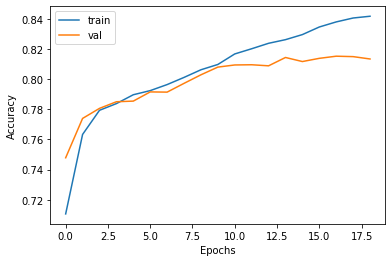

In [255]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=50, embedding_dim=256)

# Step 2: Split training and test data
X = np.asarray(names_df['name'].values.tolist())
y = np.asarray(names_df['gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                 min_delta=1e-3,
                 patience=5,
                 mode='max',
                 restore_best_weights=True,
                 verbose=1),
]

history = model.fit(x=X_train,
                   y=y_train,
                   batch_size=64,
                   epochs=100,
                   validation_data=(X_test, y_test),
                   callbacks=callbacks)

# Step 4: Save the model
model.save('boyorgirl.h5')

# Step 5: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [261]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

pred_model = load_model('boyorgirl.h5')

# Input names
names = ['Joe', 'Biden', 'Raymond', 'Kamala', 'Harris']
# Convert to datafram
pred_df = pd.DataFrame({'name': names})

def test_process(pred_df=pred_df, name_list=names):
    # Preprocess
    pred_df = preprocess(pred_df, train=False)

    # Predictions
    result = pred_model.predict(np.asarray(
        pred_df['name'].values.tolist())).squeeze(axis=1)

    pred_df['Gender'] = [
        'Male' if logit > 0.5 else 'Female' for logit in result
    ]

    pred_df['Probability'] = [
        logit if logit > 0.5 else 1.0 - logit for logit in result
    ]

    # Format the output
    pred_df['name'] = name_list
    pred_df.rename(columns={'name': 'Name'}, inplace=True)
    pred_df['Probability'] = pred_df['Probability'].round(2)
    pred_df.drop_duplicates(inplace=True)
    
    return pred_df

pred_df = test_process()
pred_df.head()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,Name,Gender,Probability
0,Joe,Male,0.54
1,Biden,Male,0.74
2,Raymond,Male,0.86
3,Kamala,Female,0.85
4,Harris,Male,0.59


In [396]:
ejara_df = pd.read_csv('./customers_with_no_gender.csv')
ejara_df.rename(columns={'username': 'name'}, inplace=True)

ejara = ejara_df['name'].values.tolist()
pred_df = pd.DataFrame({'name': ejara})

pred_df = test_process(pred_df=pred_df, name_list=ejara)
pred_df.loc[pred_df.Probability < 0.57, 'Gender'] = 'Female'

pred_df.head()

,Name,Gender,Probability
0,val,Male,0.71
1,chakaneld,Male,0.82
2,bat40,Male,0.68
3,ko,Male,0.69
4,nuerkie,Female,0.85


Male: 4506
Female: 3197


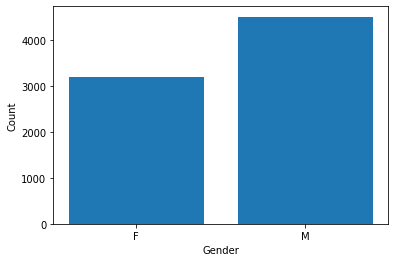

In [397]:
# df.loc[df['column_name'] == some_value]
female = pred_df.loc[pred_df['Gender'] == 'Female']
male = pred_df.loc[pred_df['Gender'] == 'Male']

plt.bar(['F', 'M'], [len(female.index), len(male.index)])
plt.xlabel('Gender')
plt.ylabel('Count')

print(f'Male: {len(male.index)}')
print(f'Female: {len(female.index)}')

In [399]:
pred_df.to_csv('ejara.csv')